# II. Deep Learning from scratch
## Convolutional Neural Networks for a cat classifer

## 1 - Packages

In [22]:
import numpy as np
import time as tm
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.python.framework import ops
from dnn_utils import *

%matplotlib inline

## 2. Convolutional Neural Networks
### 2.1 - Zero-Padding

In [ ]:
def zero_pad(X, pad):
    """
    Arguments:
        X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
        pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
        X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values=(0,))
    
    return X_pad

### 2.2 - Single step of convolution

In [ ]:
def conv_single_step(a_slice_prev, W, b):
    """
    Arguments:
        a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
        W -- weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
        b -- bias parameters contained in a window - matrix of shape (1, 1, 1)
        
    Returns:
        Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """
    
    s = np.multiply(a_slice_prev, W)
    Z = np.sum(s)
    Z = np.add(Z, np.float(b))
    
    return Z

### 2.3 - Convolutional Neural Networks - Forward pass
$$ n_H = \lfloor \frac{n_{H_{prev}} - f + 2 \times pad}{stride} \rfloor +1$$
$$ n_W = \lfloor \frac{n_{W_{prev}} - f + 2 \times pad}{stride} \rfloor +1$$
$$ n_C = \text{number of filiters used in the convolution}$$

In [ ]:
def conv_forward(A_prev, W, b, hparameters):
    """
    Arguments:
        A_prev -- output of activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
        W -- weight, numpy array of shape (f, f, n_C_prev, n_C)
        b -- biases, numpy array of shape (1, 1, 1, n_C)
        hparameters -- python dictionary containing "stride" and "pad"
    
    Returns:
        Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
        cache -- cache of values needed for the conv_backward() function
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int((n_H_prev-f+2*pad)/stride)+1
    n_W = int((n_W_prev-f+2*pad)/stride)+1
    
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i,:,:,:]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = stride*h
                    vert_end = vert_start+f
                    horiz_start = stride*w
                    horiz_end = horiz_start+f
                    
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                    
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                    
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

### 2.4 - Pooling layer
#### Forward Pooling
$$n_H = \lfloor \frac{n_{H_{prev}} - f}{stride} \rfloor + 1$$
$$n_W = \lfloor \frac{n_{W_{prev}} - f}{stride} \rfloor + 1$$
$$n_C = n_{C_{prev}}$$

In [ ]:
def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Arguments:
        A_prev -- input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
        hparameters -- python dictionary containing "f" and "stride"
        mode -- the pooling mode
        
    Returns:
        A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
        cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    n_H = int(1+(n_H_prev-f)/stride)
    n_W = int(1+(n_W_prev-f)/stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = stride*h
                    vert_end = vert_start+f
                    horiz_start = stride*w
                    horiz_end = horiz_start+f
                    
                    a_prev_slice = A_prev[i,vert_start:vert_end, horiz_start:horiz_end,c]
                    
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    return A, cache

### 2.5 - Backpropagation in convolutional neural networks
#### a) Convolutional layer backward pass
- Computing dA:
$$ dA += \sum\limits_{h = 0}^{n_{H}}{\sum\limits_{w = 0}^{n_{W}}{W_{c} \times dZ_{hw}} }$$

- Computing dW:
$$ dW_{c} += \sum\limits_{h = 0}^{n_{H}}{ \sum\limits_{w = 0}^{n_{W}}{a_{slice} \times dZ_{hw}} }$$

- Computing db:
$$ db = \sum\limits_{h}{ \sum\limits_{w}{ dZ_{hw} }} $$

In [ ]:
def conv_backward(dZ, cache):
    """
    Arguments:
        dZ -- gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
        cache -- cache of values needed for the conv_backward(), output of conv_forward()
        
    Returns:
        dA_prev -- gradient of the cost with respect to the input of the conv layer (A_prev),
                numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
        dW -- gradient of the cost with respect to the weights of the conv layer (W),
                numpy array of shape (f, f, n_C_prev, n_C)
        db -- gradient of the cost with respect to the biases of the conv layer (b),
                numpy array of shape (1, 1, 1, n_C)
    """
    
    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = h
                    vert_end = vert_start+f
                    horiz_start = w
                    horiz_end = horiz_start+f
                    
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                    
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:] += W[:,:,:,c]*dZ[i,h,w,c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
        
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad,pad:-pad,:]
    return dA_prev, dW, db

#### b) Pooling layer - backward pass
- Max pooling - backward pass

In [ ]:
def create_mask_from_window(x):
    """
    Arguments:
        x -- Array of shape (f, f)
    
    Returns:
        mask -- Array of the same shape as window, contains a True at the position corresponding to the max entry of x
    """
    
    mask = (x == np.max(x))
    
    return mask

 - Average pooling - backward pass

In [ ]:
def distribute_value(dz, shape):
    """
    Arguments:
        dz -- input scalar
        shape -- the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz
    
    Returns:
        a -- Array of size (n_H, n_W) for which we distributed the value of dz
    """
    
    (n_H, n_W) = shape
    average = dz / (n_H*n_W)
    a = np.ones(shape)*average
    
    return a

 - Putting it together: Pooling backward

In [ ]:
def pool_backward(dA, cache, mode = "max"):
    """
    Arguments:
        dA -- gradient of cost with respect to the output of the pooling layer, same shape as A
        cache -- cache output from the forward pass of the pooling layer, contains the layer's input and hparameters
        mode -- the pooling mode
    
    Returns:
        dA_prev -- gradient of cost with respect to the input of the pooling layer, same shape as A_prev
    """
    
    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    for i in range(m):
        a_prev = A_prev[i]
        
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    
                    vert_start = h
                    vert_end = vert_start+f
                    horiz_start = w
                    horiz_end = horiz_start+f
                    
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end, c] += np.multiply(mask, dA[i,h,w,c])
                    elif mode == "average":
                        da = dA[i,h,w,c]
                        shape = (f, f)
                        dA_prev[i, vert_start:vert_end, horiz_start:horiz_end,c] += distribute_value(da, shape)
        
    return dA_prev

## 3 - Application: TensorFlow model
### 3.1 - Create placeholders

In [2]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Arguments:
        n_H0 -- scalar, height of an input image
        n_W0 -- scalar, width of an input image
        n_C0 -- scalar, number of channels of the input
        n_y -- scalar, number of classes
    
    Returns:
        X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
        Y -- placeholder for the data input, of shape [None, n_y] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    
    return X, Y

### 3.2 - Initialize parameters

In [3]:
def initialize_parameters():
    """
    Returns:
        parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)
    
    W1 = tf.get_variable("W1", [4, 4, 3, 8], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 8, 16], initializer=tf.contrib.layers.xavier_initializer(seed = 0))
    
    parameters = {"W1":W1,
                  "W2":W2}
    
    return parameters

### 3.3 - Forward propagation
 - CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [4]:
def forward_propagation(X, parameters):
    """
    Arguments:
        X -- input dataset placeholder, of shape (input size, number of examples)
        parameters -- python dictionary containing parameters "W1", "W2"
                    the shapes are given in initialize_parameters
    
    Returns:
        Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    
    return Z3

In [5]:
def forward_propagation_binary(X, parameters):
    """
    Arguments:
        X -- input dataset placeholder, of shape (input size, number of examples)
        parameters -- python dictionary containing parameters "W1", "W2"
                    the shapes are given in initialize_parameters
    
    Returns:
        Z3 -- the output of the last LINEAR unit
    """
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 2, activation_fn=None)
    
    return Z3

### 3.4 - Compute cost

In [6]:
def compute_cost(Z3, Y):
    """
    Arguments:
        Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
        Y -- "true" labels vector placeholder, same shape as Z3
        
    Returns:
        cost - Tensor of the cost function
    """
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    return cost

### 3.5 - Model
 - CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

In [7]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
         num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Arguments:
        X_train -- training set, of shape (None, 64, 64, 3)
        Y_train -- training set, of shape (None, n_y = 6)
        X_test -- test set, of shape (None, 64, 64, 3)
        Y_test -- test set, of shape (None, n_y = 6)
        learning_rate -- learning rate of the optimization
        num_epochs -- number of epochs of the optimization loop
        minibatch_size -- size of a minibatch
        print_cost -- True to print the cost every 100 epochs
        
    Returns:
        train_accuracy -- real number, accuracy on the train set (X_train)
        test_accuracy -- real number, testing accuracy on the test set (X_test)
        parameters -- parameters learnt by the model. They can then be used to predict
    """
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print("Cost after epoch %i: %f" %(epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs (per fives)')
        plt.title("Learning rate ="+ str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        
        return train_accuracy, test_accuracy, parameters

In [56]:
def model_bin(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
         num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Arguments:
        X_train -- training set, of shape (None, 64, 64, 3)
        Y_train -- training set, of shape (None, n_y = 6)
        X_test -- test set, of shape (None, 64, 64, 3)
        Y_test -- test set, of shape (None, n_y = 6)
        learning_rate -- learning rate of the optimization
        num_epochs -- number of epochs of the optimization loop
        minibatch_size -- size of a minibatch
        print_cost -- True to print the cost every 100 epochs
        
    Returns:
        train_accuracy -- real number, accuracy on the train set (X_train)
        test_accuracy -- real number, testing accuracy on the test set (X_test)
        parameters -- parameters learnt by the model. They can then be used to predict
    """
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []
    
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    saver = tf.train.Saver()
    Z3 = forward_propagation_binary(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            minibatch_cost = 0.
            num_minibatches = int(m/minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            
            if print_cost == True and epoch % 5 == 0:
                print("Cost after epoch %i: %f" %(epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs (per fives)')
        plt.title("Learning rate ="+ str(learning_rate))
        plt.show()
        
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
        save_path = saver.save(sess, "test600.ckpt")
        
        print("W1: %s" %(parameters["W1"].eval()))
        
        return train_accuracy, test_accuracy, parameters

In [29]:
# Load verifying datasets
X_train = np.load("datasets/X_train_tf.npy")
Y_train = np.load("datasets/Y_train_tf.npy")
X_test = np.load("datasets/X_test_tf.npy")
Y_test = np.load("datasets/Y_test_tf.npy")
print("X_train's shape="+str(X_train.shape))
print("Y_train's shape="+str(Y_train.shape))
print("X_test's shape="+str(X_test.shape))
print("Y_test's shape="+str(Y_test.shape))

X_train's shape=(1080, 64, 64, 3)
Y_train's shape=(1080, 6)
X_test's shape=(120, 64, 64, 3)
Y_test's shape=(120, 6)


Cost after epoch 0, 1.917929
Cost after epoch 5, 1.506757
Cost after epoch 10, 0.955359
Cost after epoch 15, 0.845802
Cost after epoch 20, 0.701174
Cost after epoch 25, 0.571977
Cost after epoch 30, 0.518435
Cost after epoch 35, 0.495806
Cost after epoch 40, 0.429827
Cost after epoch 45, 0.407291
Cost after epoch 50, 0.366394
Cost after epoch 55, 0.376922
Cost after epoch 60, 0.299491
Cost after epoch 65, 0.338870
Cost after epoch 70, 0.316400
Cost after epoch 75, 0.310413
Cost after epoch 80, 0.249549
Cost after epoch 85, 0.243457
Cost after epoch 90, 0.200031
Cost after epoch 95, 0.175452


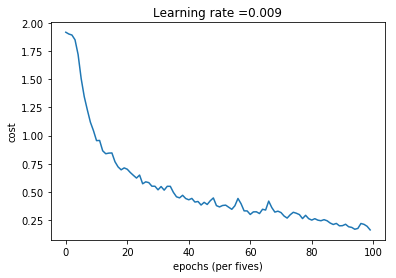

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.94074076
Test Accuracy: 0.78333336


In [20]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

#### Use my own datasets

In [8]:
# Load my datasets
X = np.load('datasets/X.npy').T
Y = np.load('datasets/Y.npy')
print("X's shape: "+str(X.shape))
print("Y's shape: "+str(Y.shape))

X's shape: (4276, 49152)
Y's shape: (4276, 1)


In [10]:
# Add another class for Y
Y_another = (Y==0)
Y_fianl = np.append(Y, Y_another, axis=1)
print("Y_fianl's shape: "+str(Y_fianl.shape))
print("Y_fianl[0,:]: "+str(Y_fianl[0,:]))

Y_fianl's shape: (4276, 2)
Y_fianl[0,:]: [0. 1.]


In [11]:
# Re-shuffle X and y_array
permutation = list(np.random.permutation(X.shape[0]))
shuffled_X = X[permutation,:]
shuffled_Y = Y_fianl[permutation,:]

print("shuffled_X's shape: "+str(shuffled_X.shape))
print("shuffled_Y's shape: "+str(shuffled_Y.shape))

shuffled_X's shape: (4276, 49152)
shuffled_Y's shape: (4276, 2)


In [12]:
m_test = np.rint(shuffled_X.shape[0]*0.05).astype(int)
m_dev = m_test
m_train = shuffled_X.shape[0]-m_test-m_dev
print("Number of training examples: " + str(m_train))
print("Number of developing examples: " + str(m_dev))
print("Number of testing examples: " + str(m_test))

assert(m_test+m_dev+m_train==shuffled_X.shape[0])

Number of training examples: 3848
Number of developing examples: 214
Number of testing examples: 214


In [13]:
x_train = shuffled_X[0:m_train,:].reshape((m_train, 128, 128, 3))
y_train = shuffled_Y[0:m_train,:]
x_dev = shuffled_X[m_train:m_train+m_dev,:].reshape((m_dev, 128, 128, 3))
y_dev = shuffled_Y[m_train:m_train+m_dev,:]
x_test = shuffled_X[m_train+m_dev:,:].reshape((m_test, 128, 128, 3))
y_test = shuffled_Y[m_train+m_dev:,:]

print("x_train's shape: "+str(x_train.shape))
print("y_train's shape: "+str(y_train.shape))
print("y_test's shape: "+str(y_test.shape))

x_train's shape: (3848, 128, 128, 3)
y_train's shape: (3848, 2)
y_test's shape: (214, 2)


#### Test with my dev sets

Cost after epoch 0: 0.926986
Cost after epoch 5: 0.851643
Cost after epoch 10: 0.795438
Cost after epoch 15: 0.645108
Cost after epoch 20: 0.681975
Cost after epoch 25: 0.522157
Cost after epoch 30: 0.472304
Cost after epoch 35: 0.354651
Cost after epoch 40: 0.401117
Cost after epoch 45: 0.208873
Cost after epoch 50: 0.182736
Cost after epoch 55: 0.123981
Cost after epoch 60: 0.091238
Cost after epoch 65: 0.078298
Cost after epoch 70: 0.053223
Cost after epoch 75: 0.043759
Cost after epoch 80: 0.029280
Cost after epoch 85: 0.021950
Cost after epoch 90: 0.017818
Cost after epoch 95: 0.018195


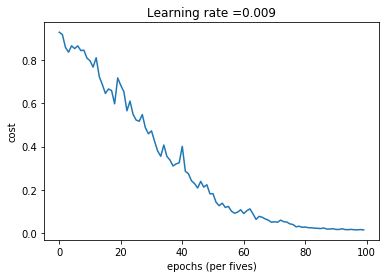

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 1.0
Test Accuracy: 0.7196262
W1: [[[[ 0.25282872  0.23260306  0.34102333 -0.24627466 -0.01369825
     0.0051094  -0.21355021  0.22327772]
   [ 0.3803174   0.42754072  0.10997767  0.1457808   0.25983715
    -0.01784311 -0.17105514  0.30204308]
   [ 0.37086257  0.31878445  0.24725111  0.2757737  -0.10320465
    -0.16356349 -0.2616226   0.02438127]]

  [[-0.04214784  0.0043519   0.02595657 -0.09657574 -0.1374759
    -0.3329386  -0.1615394  -0.0371362 ]
   [ 0.45313868  0.19858325  0.33197522  0.11872414 -0.20890999
    -0.40580174 -0.06080479  0.33225664]
   [ 0.36281744  0.03238925  0.2150696   0.2867736   0.10303967
    -0.37589985 -0.238858   -0.13572423]]

  [[ 0.32596377 -0.20049724 -0.09225262 -0.32610333  0.01476453
    -0.05380508  0.12768248 -0.11778519]
   [ 0.1869535  -0.01930338  0.15497673 -0.04357817 -0.17477971
    -0.1404324   0.38011062  0.10029833]
   [ 0.44480997 -0.20494545  0.12506634 -0.14714663 -0.08103758


In [53]:
start_time = tm.time()
_, _, parameters = model_bin(x_dev, y_dev, x_test, y_test)
print("--- %s seconds ---" %(tm.time()-start_time))

#### Test with my train sets

In [ ]:
start_time = tm.time()
_, _, parameters = model_bin(x_train, y_train, x_test, y_test, num_epochs = 600)
print("--- %s seconds ---" %(tm.time()-start_time))

Cost after epoch 0: 0.638702
Cost after epoch 5: 0.494891
Cost after epoch 10: 0.474147
Cost after epoch 15: 0.456671
Cost after epoch 20: 0.475379
Cost after epoch 25: 0.432453
Cost after epoch 30: 0.409218
Cost after epoch 35: 0.399584
Cost after epoch 40: 0.384551
Cost after epoch 45: 0.370302
Cost after epoch 50: 0.363364
Cost after epoch 55: 0.371953
Cost after epoch 60: 0.341679
Cost after epoch 65: 0.348393
Cost after epoch 70: 0.318381
Cost after epoch 75: 0.314611
Cost after epoch 80: 0.326100
Cost after epoch 85: 0.332468
Cost after epoch 90: 0.302708
Cost after epoch 95: 0.312325
Cost after epoch 100: 0.315317
Cost after epoch 105: 0.298614
Cost after epoch 110: 0.294482
Cost after epoch 115: 0.306181
Cost after epoch 120: 0.355521
Cost after epoch 125: 0.303523
Cost after epoch 130: 0.304977
Cost after epoch 135: 0.271467
Cost after epoch 140: 0.323059
Cost after epoch 145: 0.250341
Cost after epoch 150: 0.279954
Cost after epoch 155: 0.358550
Cost after epoch 160: 0.288659

#### Image Reference
- [cat](http://www.browntrout.com/9781465088321.html)
- [wolf](http://www.spoilersguide.com/uncategorized/spoilers-is-bran-starks-son-dead/)

INFO:tensorflow:Restoring parameters from test.ckpt
W1: [[[[ 3.17970514e-02  3.61914068e-01  1.61712363e-01 -7.99643850e+00
    -1.00142181e-01 -1.41937554e+00  2.99311370e-01  4.06327158e-01]
   [ 3.89698863e-01  1.08909881e+00 -1.21932888e+00 -9.36315805e-02
     6.63291514e-01 -4.14072067e-01  2.90188432e-01 -4.21417803e-01]
   [ 1.80422330e+00  9.91826653e-02 -1.41135049e+00  3.64802182e-01
    -4.65720129e+00 -4.74522300e-02 -6.80844009e-01  3.64757627e-01]]

  [[-1.01743007e+00 -3.04047078e-01  1.05954260e-01 -3.99763918e+00
    -1.79000020e+00 -1.89873493e+00 -6.22183323e-01 -1.80073842e-01]
   [-8.35132182e-01  2.36310765e-01  3.85078639e-01  5.96856534e-01
     6.73606515e-01 -1.39349687e+00  2.60458410e-01  3.13142776e-01]
   [-1.36263859e+00 -3.44640404e-01  1.26763463e+00  1.82902718e+00
    -6.35117245e+00 -1.44210088e+00 -1.07995546e+00 -9.06770051e-01]]

  [[ 1.05969584e+00 -3.70378464e-01  6.57953322e-01 -3.66296840e+00
    -1.04539919e+00 -3.78507823e-02 -4.17775884e-0

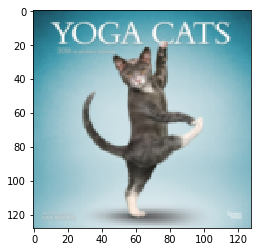

In [55]:
my_cat_image = "images/cat.jpg"
my_label_y = np.float32(np.array([[1, 0]])) # This is a cat

x_cat = []
with Image.open(my_cat_image) as im:
    if im.mode == 'RGB':
        nim = im.resize((128, 128), Image.BILINEAR)
        pixel_values = np.array(nim.getdata()).reshape((128, 128, 3))
        x_cat.append(pixel_values)
x_cat_orig = np.array(x_cat)
plt.imshow(x_cat_orig[0])
x_cat_data = (x_cat_orig/255.).astype(np.float32)

(m, n_H0, n_W0, n_C0) = x_cat_data.shape
n_y = my_label_y.shape[1]

tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    saver = tf.train.Saver()
    saver.restore(sess, "test.ckpt")
    print("W1: %s" %(parameters["W1"].eval()))
    Z3 = forward_propagation_binary(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: x_cat_data, Y: my_label_y})
    print("Z3 = "+str(a))

In [24]:
my_n_cat_image = "images/wolf.png"
my_n_label_y = np.array([[0, 1]]) # This is not a cat

x_n_cat = []
with Image.open(my_n_cat_image) as im:
    if im.mode == 'RGB':
        nim = im.resize((width, height), Image.BILINEAR)
        pixel_values = np.array(nim.getdata()).reshape((128, 128, 3))
        x_n_cat.append(pixel_values)
x_n_cat_orig = np.array(x_n_cat)
print(x_n_cat_orig.shape)
#plt.imshow(x_n_cat_orig[0])
x_n_cat_data = x_n_cat_orig/255.

(m, n_H0, n_W0, n_C0) = x_n_cat_data.shape
n_y = my_n_label_y.shape[1]

tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    Z3 = forward_propagation_binary(x_n_cat_data, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: x_cat, Y: my_label_y})
    print("Z3 = "+str(a))

(0,)


ValueError: not enough values to unpack (expected 4, got 1)